 # How to Classify Photos of Dogs and Cats (with 97% accuracy)
 reference: https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/

## Dogs vs. Cats Dataset Preparation
Download the dataset by visiting the Dogs vs. Cats Data page and click the “Download All” button.

This will download the 850-megabyte file “dogs-vs-cats.zip” to your workstation.

Unzip the file and you will see train.zip, train1.zip and a .csv file. Unzip the train.zip file, as we will be focusing only on this dataset.

You will now have a folder called ‘train/‘ that contains 25,000 .jpg files of dogs and cats. The photos are labeled by their filename, with the word “dog” or “cat“. The file naming convention is as follows:

cat.124999.jpg <br>
... <br> 
dog.0.jpg <br> 
dog.124999.jpg <br>

In [1]:

import os
!pwd

os.chdir("/expanse/lustre/scratch/jenmar528/temp_project/")
!pwd
!ls

/home/jenmar528
/expanse/lustre/scratch/jenmar528/temp_project
bee_data      bee_data.zip    butterfly_data.zip    testdir
bee_data.csv  butterfly_data  dataset_dogs_vs_cats


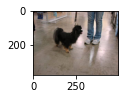

In [2]:
# plot dog photos from the dogs vs cats dataset
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset


#!cd 
folder = 'dataset_dogs_vs_cats/train/dogs/'
# plot first few images
#for i in range(9):
	# define subplot
	#pyplot.subplot(330 + 1 + i)
	# define filename
	#filename = folder + 'dog.' + str(i) + '.jpg'
	# load image pixels
	#image = imread(filename)
	# plot raw pixel data
	#pyplot.imshow(image)

pyplot.subplot(330 + 1)
filename = folder + 'dog.1000.jpg'
image = imread(filename)
pyplot.imshow(image)
    
    
    
# show the figure
pyplot.show()

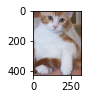

In [3]:

# plot first few images
#for i in range(9):
	# define subplot
	#pyplot.subplot(330 + 1 + i)
	# define filename
	#filename = folder + 'cat.' + str(i) + '.jpg'
	# load image pixels
	#image = imread(filename)
	# plot raw pixel data
	#pyplot.imshow(image)

#!cd 
folder = 'dataset_dogs_vs_cats/train/cats/'
# plot first few images
#for i in range(9):
	# define subplot
	#pyplot.subplot(330 + 1 + i)
	# define filename
	#filename = folder + 'dog.' + str(i) + '.jpg'
	# load image pixels
	#image = imread(filename)
	# plot raw pixel data
	#pyplot.imshow(image)

pyplot.subplot(330 + 1)
filename = folder + 'cat.9.jpg'
image = imread(filename)
pyplot.imshow(image)
    
    
    
# show the figure
pyplot.show()

The photos will have to be reshaped prior to modeling so that all images have the same shape. This is often a small square image.

There are many ways to achieve this, although the most common is a simple resize operation that will stretch and deform the aspect ratio of each image and force it into the new shape.

We could load all photos and look at the distribution of the photo widths and heights, then design a new photo size that best reflects what we are most likely to see in practice.

Smaller inputs mean a model that is faster to train, and typically this concern dominates the choice of image size. In this case, we will follow this approach and choose a fixed size of 200×200 pixels.

## Pre-Process Photos into Standard Directories
Alternately, we can load the images progressively using the Keras ImageDataGenerator class and flow_from_directory() API. This will be slower to execute but will run on more machines.

This API prefers data to be divided into separate train/ and test/ directories, and under each directory to have a subdirectory for each class, e.g. a train/dog/ and a train/cat/ subdirectories and the same for test. Images are then organized under the subdirectories.



dataset_dogs_vs_cats <br>
├── test <br> 
│     ├── cats <br> 
│     └── dogs <br> 
└── train <br> 
|    ├── cats <br> 
|    └── dogs <br>

In [4]:
# load dogs vs cats dataset, reshape and save to a new file
import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

In [5]:
# create directories
dataset_home = 'dataset_dogs_vs_cats/'
subdirs = ['train/', 'test/']
#for subdir in subdirs:
#	# create label subdirectories
#	labeldirs = ['dogs/', 'cats/']
#	for labldir in labeldirs:
#		newdir = dataset_home + subdir + labldir
#		os.makedirs(newdir, exist_ok=True)

In [6]:
import random
import shutil
# seed random number generator
random.seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories
src_directory = 'train/'
# for file in os.listdir(src_directory):
#	src = src_directory + '/' + file
#	dst_dir = 'train/'
#	if random.random() < val_ratio:
#		dst_dir = 'test/'
#	if file.startswith('cat'):
#		dst = dataset_home + dst_dir + 'cats/'  + file
#		shutil.copyfile(src, dst)
#	elif file.startswith('dog'):
#		dst = dataset_home + dst_dir + 'dogs/'  + file
#		shutil.copyfile(src, dst)

## Develop a Baseline CNN Model
In this section, we can develop a baseline convolutional neural network model for the dogs vs. cats dataset.

A baseline model will establish a minimum model performance to which all of our other models can be compared, as well as a model architecture that we can use as the basis of study and improvement.

The architecture involves stacking convolutional layers with small 3×3 filters followed by a max pooling layer. Together, these layers form a block, and these blocks can be repeated where the number of filters in each block is increased with the depth of the network such as 32, 64, 128, 256 for the first four blocks of the model. Padding is used on the convolutional layers to ensure the height and width shapes of the output feature maps matches the inputs.

We can explore this architecture on the dogs vs cats problem and compare a model with this architecture with 1, 2, and 3 blocks.

Each layer will use the ReLU activation function and the He weight initialization, which are generally best practices. For example, a 3-block VGG-style architecture where each block has a single convolutional and pooling layer can be defined in Keras as follows:

In [13]:
# baseline model for the dogs vs cats dataset
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

In [14]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [15]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()

In [16]:
# if image is bugged, do not use it
def my_gen(gen):
    while True:
        try:
            data, labels = next(gen)
            yield data, labels
        except:
            pass

In [28]:
# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	print("got past test_it")
	# fit model
	# old version
	# history = model.fit(train_it, steps_per_epoch=len(train_it),
		# validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
	history = model.fit(my_gen(train_it), steps_per_epoch=len(train_it),
		validation_data=my_gen(test_it), validation_steps=len(test_it), epochs=5, verbose=1)
	print("got past history")
	#return model
	# evaluate model
	_, acc = model.evaluate(test_it, steps=len(test_it), verbose=1)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)
 

In [29]:
# entry point, run the test harness
run_test_harness()

Found 1520 images belonging to 2 classes.
Found 482 images belonging to 2 classes.
got past test_it
Epoch 1/5
24/24 [==============================] - 7s 295ms/step - loss: 0.8180 - accuracy: 0.5079 - val_loss: 0.6932 - val_accuracy: 0.5166
Epoch 2/5
24/24 [==============================] - 7s 293ms/step - loss: 0.6796 - accuracy: 0.5526 - val_loss: 0.6804 - val_accuracy: 0.5685
Epoch 3/5
24/24 [==============================] - 7s 294ms/step - loss: 0.6842 - accuracy: 0.5645 - val_loss: 0.6863 - val_accuracy: 0.5124
Epoch 4/5
24/24 [==============================] - 7s 294ms/step - loss: 0.6593 - accuracy: 0.6145 - val_loss: 0.6818 - val_accuracy: 0.5747
Epoch 5/5
24/24 [==============================] - 7s 293ms/step - loss: 0.6663 - accuracy: 0.6000 - val_loss: 0.6940 - val_accuracy: 0.5083
got past history
8/8 [==============================] - 1s 150ms/step - loss: 0.6923 - accuracy: 0.5145
> 51.452


## One Block VGG Model
The one-block VGG model has a single convolutional layer with 32 filters followed by a max pooling layer.

The define_model() function for this model was defined in the previous section but is provided again below for completeness.

In [ ]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

## Dropout Regulation


In [ ]:
# baseline model with dropout for the dogs vs cats dataset
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
 
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.5))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model
 
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()
 
# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterator
	train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=0)
	# evaluate model
	_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)
 
# entry point, run the test harness
# run_test_harness()

## Image Data Augmentation
Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset.

Training deep learning neural network models on more data can result in more skillful models, and the augmentation techniques can create variations of the images that can improve the ability of the fit models to generalize what they have learned to new images.

Data augmentation can also act as a regularization technique, adding noise to the training data, and encouraging the model to learn the same features, invariant to their position in the input.

Small changes to the input photos of dogs and cats might be useful for this problem, such as small shifts and horizontal flips. These augmentations can be specified as arguments to the ImageDataGenerator used for the training dataset. The augmentations should not be used for the test dataset, as we wish to evaluate the performance of the model on the unmodified photographs.

This requires that we have a separate ImageDataGenerator instance for the train and test dataset, then iterators for the train and test sets created from the respective data generators. For example:

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generators
	train_datagen = ImageDataGenerator(rescale=1.0/255.0,
		width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
	test_datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = train_datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = test_datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=0)
	# evaluate model
	_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()